In [1]:
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
%matplotlib inline

Using TensorFlow backend.


In [2]:
# 此函數會幫我們把多張影像畫成一張多宮格圖
def img_combine(img, ncols=8, size=1, path=False):
    from math import ceil
    import matplotlib.pyplot as plt
    import numpy as np
    nimg = len(img)
    nrows = int(ceil(nimg/ncols))
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True, figsize=(ncols*size,nrows*size))
    if nrows == 0:
        return
    elif ncols == 1:
        for r, ax in zip(np.arange(nrows), axes):
            nth=r
            if nth < nimg:
                ax.imshow(img[nth], cmap='rainbow', vmin=0, vmax=1)
                
            ax.set_axis_off()
    elif nrows == 1:
        for c, ax in zip(np.arange(ncols), axes):
            nth=c
            if nth < nimg:
                ax.imshow(img[nth], cmap='rainbow', vmin=0, vmax=1)
            ax.set_axis_off()
    else:
        for r, row in zip(np.arange(nrows), axes):
            for c, ax in zip(np.arange(ncols), row):
                nth=r*ncols+c
                if nth < nimg:
                    ax.imshow(img[nth], cmap='rainbow', vmin=0, vmax=1)
                ax.set_axis_off()
    plt.show()

In [3]:
# 讀取 Cifar-10 資料集
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

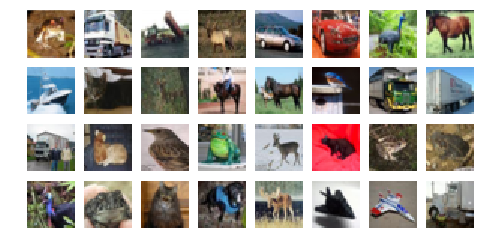

In [4]:
# 取前 32 張圖片做視覺化
images = x_train[:32]
img_combine(images)

In [5]:
# 建立 ImageDataGenerator，並指定我們要做資料增強的數值範圍
data_generator = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

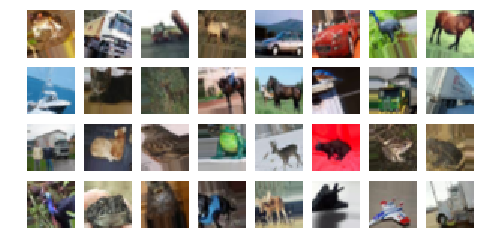

In [6]:
# 注意！！ ImageDataGenerator 是一個 Generator (生成器)! 對 Generator 不熟悉的同學請回到 Day098 做複習。
# 使用 .flow 後，就會對我們的影像進行增強，再 call next 取出 generator 的圖像。(shuffle=False 因為我們希望圖像的順序不要改變，方便觀察。實際訓練時預設是 shuffle=True) 
augmented_iamges = next(data_generator.flow(images, shuffle=False))
img_combine(augmented_iamges.astype("int")) # 注意在訓練時神經網路時，圖像資料必須要是 float32，但在做視覺化時要轉為 int 才能順利畫圖。所以為了畫圖才把資料轉為 int

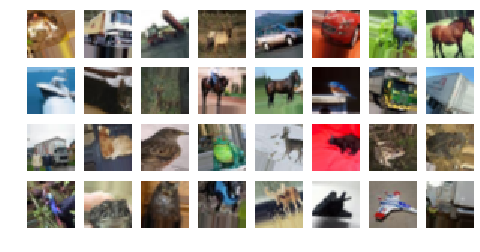

In [7]:
# 因為隨機性的關係，所以一樣的圖像再經過一次 generator 後的結果不一定相同
augmented_iamges = next(data_generator.flow(images, shuffle=False))
img_combine(augmented_iamges.astype("int"))

## 作業

請使用 ImageDataGenerator 來進行 Cifar-10 資料集的訓練，並觀察不同的圖像增強方法是否會顯著影響訓練結果

In [8]:
from math import ceil

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import RMSprop, Adam

batch_size = 128 # batch 的大小，如果出現 OOM error，請降低這個值
num_classes = 10 # 類別的數量，Cifar 10 共有 10 個類別
epochs = 10 # 訓練的 epochs 數量

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [9]:
def get_model(input_shape, output_size):
    model = Sequential()
    model.add(Conv2D(16, (3, 3), padding='same',
                     input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(Conv2D(16, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(32, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(output_size))
    model.add(Activation('softmax'))
    
    return model

In [10]:
data_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)
model = get_model(x_train.shape[1:], num_classes)
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])
history = model.fit_generator(data_generator.flow(x_train, y_train, batch_size=batch_size),
                              steps_per_epoch=int(ceil(len(x_train) / batch_size)),
                              epochs=epochs,
                              verbose=1,
                              validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Epoch 1/10
391/391 [==============================] - 24s 62ms/step - loss: 1.9057 - acc: 0.2969 - val_loss: 11.8399 - val_acc: 0.2538
Epoch 2/10
391/391 [==============================] - 24s 61ms/step - loss: 1.6763 - acc: 0.3861 - val_loss: 11.1509 - val_acc: 0.3013
Epoch 3/10
391/391 [==============================] - 24s 61ms/step - loss: 1.5687 - acc: 0.4276 - val_loss: 11.0618 - val_acc: 0.3058
Epoch 4/10
391/391 [==============================] - 24s 61ms/step - loss: 1.4987 - acc: 0.4557 - val_loss: 11.3146 - val_acc: 0.2912
Epoch 5/10
391/391 [==============================] - 24s 61ms/step - loss: 1.4439 - acc: 0.4744 - val_loss: 11.4444 - val_acc: 0.2851
Epoch 6/10
391/391 [==============================] - 24s 61ms/step - loss: 1.4054 - acc: 

In [11]:
data_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=False)
model = get_model(x_train.shape[1:], num_classes)
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])
history = model.fit_generator(data_generator.flow(x_train, y_train, batch_size=batch_size),
                              steps_per_epoch=int(ceil(len(x_train) / batch_size)),
                              epochs=epochs,
                              verbose=1,
                              validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/10
391/391 [==============================] - 24s 62ms/step - loss: 1.8561 - acc: 0.3247 - val_loss: 11.3880 - val_acc: 0.2864
Epoch 2/10
391/391 [==============================] - 24s 60ms/step - loss: 1.5487 - acc: 0.4406 - val_loss: 10.5951 - val_acc: 0.3340
Epoch 3/10
391/391 [==============================] - 24s 61ms/step - loss: 1.4044 - acc: 0.4961 - val_loss: 10.6865 - val_acc: 0.3290
Epoch 4/10
391/391 [==============================] - 24s 61ms/step - loss: 1.3208 - acc: 0.5266 - val_loss: 9.4664 - val_acc: 0.4022
Epoch 5/10
391/391 [==============================] - 24s 61ms/step - loss: 1.2494 - acc: 0.5552 - val_loss: 10.1476 - val_acc: 0.3625
Epoch 6/10
391/391 [==============================] - 24s 61ms/step - loss: 1.1975 - acc: 0.5773 - val_loss: 9.4736 - val_acc: 0.4026
Epoch 7/10
391/391 [==============================] - 24s 61ms/step - loss: 1.1513 - acc: 0.5922 - val_loss: 9.6605 - val_acc: 0.3900
Epoch 8/10
391/391 [==============================] - 24s 

In [12]:
data_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=0,
    width_shift_range=0.0,
    height_shift_range=0.0,
    horizontal_flip=False)
model = get_model(x_train.shape[1:], num_classes)
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])
history = model.fit_generator(data_generator.flow(x_train, y_train, batch_size=batch_size),
                              steps_per_epoch=int(ceil(len(x_train) / batch_size)),
                              epochs=epochs,
                              verbose=1,
                              validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/10
391/391 [==============================] - 23s 58ms/step - loss: 1.7793 - acc: 0.3546 - val_loss: 10.5666 - val_acc: 0.3331
Epoch 2/10
391/391 [==============================] - 22s 56ms/step - loss: 1.4444 - acc: 0.4844 - val_loss: 8.7683 - val_acc: 0.4448
Epoch 3/10
391/391 [==============================] - 22s 56ms/step - loss: 1.2877 - acc: 0.5453 - val_loss: 8.0390 - val_acc: 0.4909
Epoch 4/10
391/391 [==============================] - 22s 57ms/step - loss: 1.1742 - acc: 0.5874 - val_loss: 8.3813 - val_acc: 0.4703
Epoch 5/10
391/391 [==============================] - 22s 56ms/step - loss: 1.0923 - acc: 0.6161 - val_loss: 8.2023 - val_acc: 0.4803
Epoch 6/10
391/391 [==============================] - 22s 56ms/step - loss: 1.0292 - acc: 0.6412 - val_loss: 7.8803 - val_acc: 0.4999
Epoch 7/10
391/391 [==============================] - 22s 56ms/step - loss: 0.9757 - acc: 0.6582 - val_loss: 7.9521 - val_acc: 0.4952
Epoch 8/10
391/391 [==============================] - 22s 56m